In [11]:
import pandas as pd
import numpy as np
df=pd.read_csv('./parsed data/table.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67542 entries, 0 to 67541
Data columns (total 8 columns):
organization                            67542 non-null bool
payload_coleman_liau_index              67542 non-null float64
is_spam                                 67542 non-null bool
multipart_count                         67542 non-null int64
frm_fuzz_set_ratio                      67542 non-null float64
cc                                      67542 non-null bool
payload_dale_chall_readability_score    67542 non-null float64
payload_smog_index                      67542 non-null float64
dtypes: bool(3), float64(4), int64(1)
memory usage: 2.8 MB


In [2]:
#normalize data
for col in df:
    if df[col].dtype!="bool":
        df[col]=df[col]/np.max(df[col])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

if 'is_spam' in df:
    y = df['is_spam'].values # get the labels we want
    del df['is_spam'] # get rid of the class label
    X = df.values# use everything else to predict!

lr_sk = LogisticRegression() # all params default

%time lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 267 ms, sys: 6.22 ms, total: 273 ms
Wall time: 273 ms
[[-6.99939435  0.01130614 -0.07557123 -0.02627591 -6.02302125 -0.07917765
   0.08397365]]
Accuracy of:  0.955790471114


In [4]:
#Training/testing 
from sklearn.cross_validation import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = .8)
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions
    conf=mt.confusion_matrix(y[test_indices],y_hat)
    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",conf)
    print("false positive", conf[0][1]/np.sum(conf)) 
    print("false negative", conf[1][0]/np.sum(conf)) 

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


====Iteration 0  ====
accuracy 0.955490987156
confusion matrix
 [[32022   502]
 [ 1903 19607]]
false positive 0.00929044675575
false negative 0.035218566088
====Iteration 1  ====
accuracy 0.955583521486
confusion matrix
 [[32070   518]
 [ 1882 19564]]
false positive 0.0095865566125
false negative 0.034829921901
====Iteration 2  ====
accuracy 0.95636080986
confusion matrix
 [[32065   505]
 [ 1853 19611]]
false positive 0.00934596735389
false negative 0.0342932227857


In [5]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
import plotly
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.



In [6]:
import plotly
plotly.offline.init_notebook_mode()
error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

In [33]:
#classification with three greatest weights(just for fun, can be removed)
'''X_new=df[['cc','organization','payload_coleman_liau_index']].values
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = .2)
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    lr_clf.fit(X_new[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X_new[test_indices]) # get test set precitions
    conf=mt.confusion_matrix(y[test_indices],y_hat)
    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",conf)
    print("false positive", conf[0][1]/np.sum(conf)) 
    print("false negative", conf[1][0]/np.sum(conf)) '''

'X_new=df[[\'cc\',\'organization\',\'payload_coleman_liau_index\']].values\ncv_object = ShuffleSplit(n=num_instances,\n                         n_iter=num_cv_iterations,\n                         test_size  = .2)\n# run logistic regression and vary some parameters\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn import metrics as mt\nlr_clf = LogisticRegression(penalty=\'l2\', C=1.0, class_weight=None)\n# first we create a reusable logisitic regression object\n#   here we can setup the object with different learning parameters and constants\nfor iter_num, (train_indices, test_indices) in enumerate(cv_object):\n    lr_clf.fit(X_new[train_indices],y[train_indices])  # train object\n    y_hat = lr_clf.predict(X_new[test_indices]) # get test set precitions\n    conf=mt.confusion_matrix(y[test_indices],y_hat)\n    # print the accuracy and confusion matrix \n    print("====Iteration",iter_num," ====")\n    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) \n    pr

In [7]:
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='lbfgs',n_jobs=-1) # all params default
# note that sklearn is optimized for using the liblinear library with logistic regression
# ...and its faster than our implementation here

%time lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 82.9 ms, sys: 22.9 ms, total: 106 ms
Wall time: 504 ms
[[-6.81109573  5.12364925 -0.11913789 -2.63011579 -6.21672138 -2.96972294
   4.54659493]]
Accuracy of:  0.955805276717


In [8]:
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='liblinear',n_jobs=4) 

%time lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 125 ms, sys: 8.63 ms, total: 134 ms
Wall time: 134 ms
[[-6.78043117  4.86097091 -0.02503204 -2.56110309 -6.2074862  -2.64180897
   4.55852451]]
Accuracy of:  0.955805276717


In [9]:
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='newton-cg',n_jobs=4) 

%time lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 79.6 ms, sys: 31.9 ms, total: 111 ms
Wall time: 503 ms
[[-6.81118584  5.12618082 -0.11720335 -2.62992598 -6.21677856 -2.96401465
   4.54549634]]
Accuracy of:  0.955805276717


In [13]:
from sklearn.svm import SVC
clf = SVC(gamma=.4,kernel='sigmoid')
clf.fit(X, y) 
yhat = clf.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

Accuracy of:  0.528263895058


In [38]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X,y)
yhat=gnb.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

Accuracy of:  0.953125462675


In [39]:
from sklearn.naive_bayes import MultinomialNB 
gnb = MultinomialNB()
gnb.fit(np.abs(X),y)
yhat=gnb.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

Accuracy of:  0.949631340499


In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression

# select model
clf = LogisticRegression(C=.2)

#select cross validation
cv = StratifiedKFold(n_splits=10)
# select evaluation criteria
my_scorer = make_scorer(recall_score)
# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

(0.76086438152011926, 0.9567809239940388)

In [15]:
# select model
clf = SVC(gamma=.4,kernel='sigmoid')

#select cross validation
cv = StratifiedKFold(n_splits=20)
# select evaluation criteria
my_scorer = make_scorer(recall_score)
# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

(0.24037257824143071, 0.94485842026825628)

In [58]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)


In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=200,random_state=1)),
                    ('clf', LogisticRegression(class_weight='balanced', random_state=1))])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred))

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning:

Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.



             precision    recall  f1-score   support

      False       0.95      0.98      0.96      8204
       True       0.97      0.92      0.94      5305

avg / total       0.96      0.96      0.96     13509



/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.



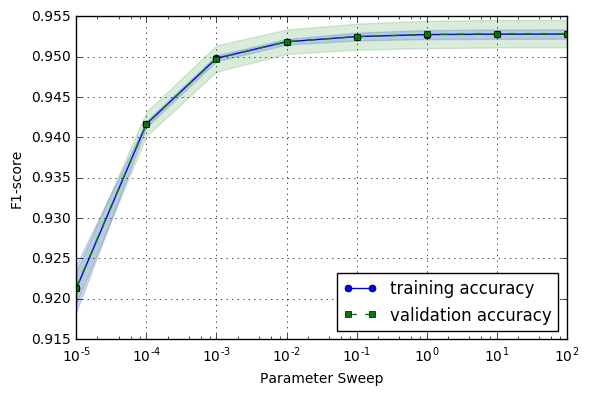

In [67]:
from sklearn.learning_curve import validation_curve
def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()

scorer = make_scorer(f1_score, average='macro')
param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]

train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                scoring = scorer,
                param_name='clf__C', 
                param_range=param_range,
                cv=5,n_jobs=-1)

plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.ylabel('F1-score')
plt.show()

In [76]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=20,
                                                       n_jobs=-1)


/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning:

Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.

/Users/arslanmemon/miniconda2/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning:

Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver

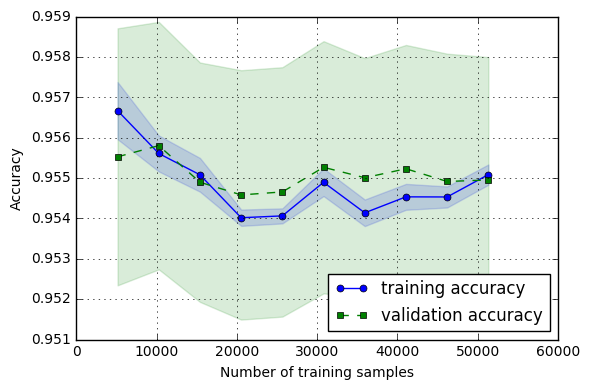

In [77]:
plt.figure()
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')